In [61]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [62]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Loading objects from a Joblib

In [63]:
## Load the joblib file stored in the models folder
fname = "best-models.joblib"
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'linear Regression', 'RandomForest'])

In [64]:
X_train_df = loaded['X_train']
y_train = loaded['y_train']
X_test_df = loaded['X_test']
y_test = loaded['y_test']
preprocessor = loaded['preprocessor']
lin_reg = loaded['linear Regression']
loaded_model = loaded['RandomForest']

In [65]:
evaluate_regression(loaded_model,X_train_df, y_train, X_test_df,y_test)

In [66]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [67]:
len(X_train_df)

6392

In [68]:
# Take a sample of the training data (nsampel=800, use random_state=SEED)
X_shap = shap.sample(X_train_df,nsamples = 800,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_MRP  Item_Fat_Content_regular  Item_Type_Breads  \
3888        15.85   36.9506                       1.0               0.0   
2497        15.10  221.8456                       1.0               0.0   
7723        17.50  184.8266                       0.0               0.0   
8117        10.80  243.2144                       0.0               0.0   
7475        15.00  140.4838                       0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
3888                  0.0               0.0              0.0   
2497                  0.0               0.0              0.0   
7723                  0.0               0.0              0.0   
8117                  0.0               0.0              0.0   
7475                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
3888                     1.0                              0.0   
2497                     0.0                              1.0   
7723                     0.0                              1.0   
8117                     0.0                              1.0   
7475                     0.0                              0.0   

      Item_Type_Hard Drinks  ...  Outlet_Identifier_OUT046  \
3888                    0.0  ...                       0.0   
2497                    0.0  ...                       1.0   
7723                    0.0  ...                       0.0   
8117                    0.0  ...                       0.0   
7475                    0.0  ...                       0.0   

      Outlet_Identifier_OUT049  Outlet_Size_MISSING  Outlet_Size_Medium  \
3888                       0.0                  1.0                 0.0   
2497                       0.0                  0.0                 0.0   
7723                       0.0                  1.0                 0.0   
8117                       0.0                  1.0                 0.0   
7475                       0.0                  1.0                 0.0   

      Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
3888                0.0                          1.0   
2497                1.0                          0.0   
7723                0.0                          1.0   
8117                0.0                          1.0   
7475                0.0                          1.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
3888                          0.0                            1.0   
2497                          0.0                            1.0   
7723                          0.0                            1.0   
8117                          0.0                            1.0   
7475                          0.0                            1.0   

      Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
3888                            0.0                            0.0  
2497                            0.0                            0.0  
7723                            0.0                            0.0  
8117                            0.0                            0.0  
7475                            0.0                            0.0  

[5 rows x 35 columns]

## Explaining Our RandomForest

In [85]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(loaded_model)

In [84]:
## Getting the shap values wth the local X_shap 
shap_values = explainer(X_shap,y_shap)

In [86]:
X_shap.shape

(800, 35)

In [89]:
shap_values.shape

(800, 35)

In [88]:
shap_values[0]

.values =
array([-7.31267936e+00, -1.67476171e+03,  6.78205134e+00, -4.41680509e-01,
       -8.82287672e-01, -1.32049671e+00,  1.51724039e+00,  2.48387419e+01,
       -2.50651825e+00, -7.82746574e-01, -8.55104733e+00, -6.57848888e-01,
       -1.39364825e+00, -8.67453989e-01, -1.28498424e+00, -1.56945984e+00,
       -3.19255296e+00,  3.27203108e+00, -1.17209772e+00,  2.59096401e+01,
       -2.73952795e+01,  3.38953238e+00, -4.62280027e+01,  6.33289098e-01,
        9.12304376e+00,  2.14228883e+00, -8.76734086e-01, -5.34105347e+00,
       -2.20902315e+01,  4.36604905e+00, -3.45584293e+00, -7.26129455e-01,
        2.41887881e+02, -2.24451430e+01, -5.57773008e+01])

.base_values =
array([2207.5242624])

.data =
array([15.85  , 36.9506,  1.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        1.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,
    

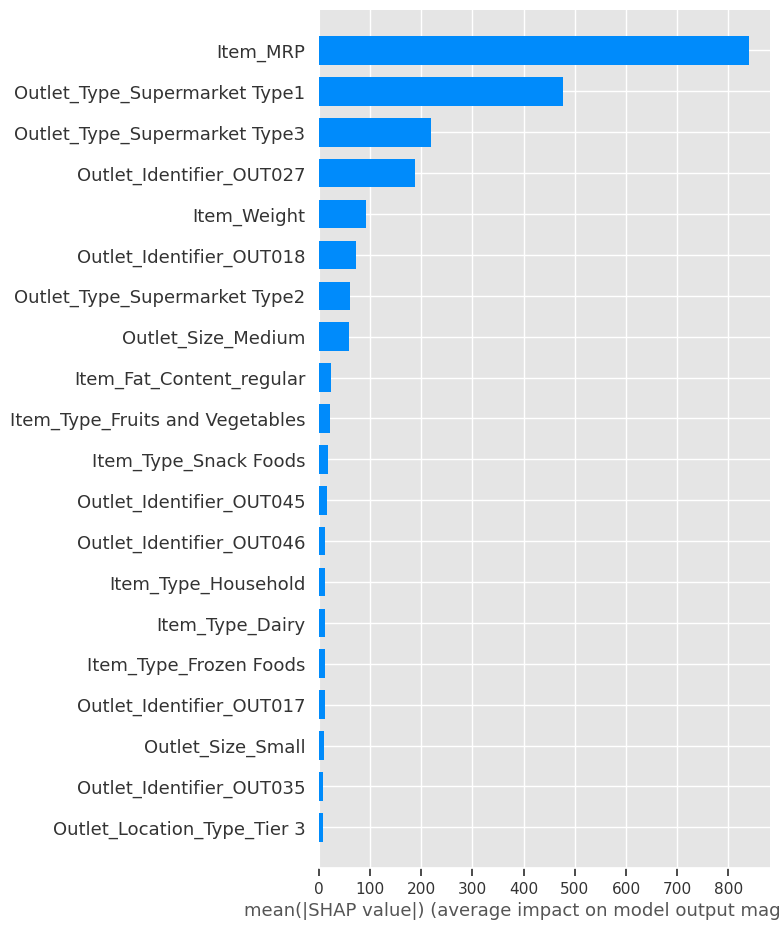

In [90]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

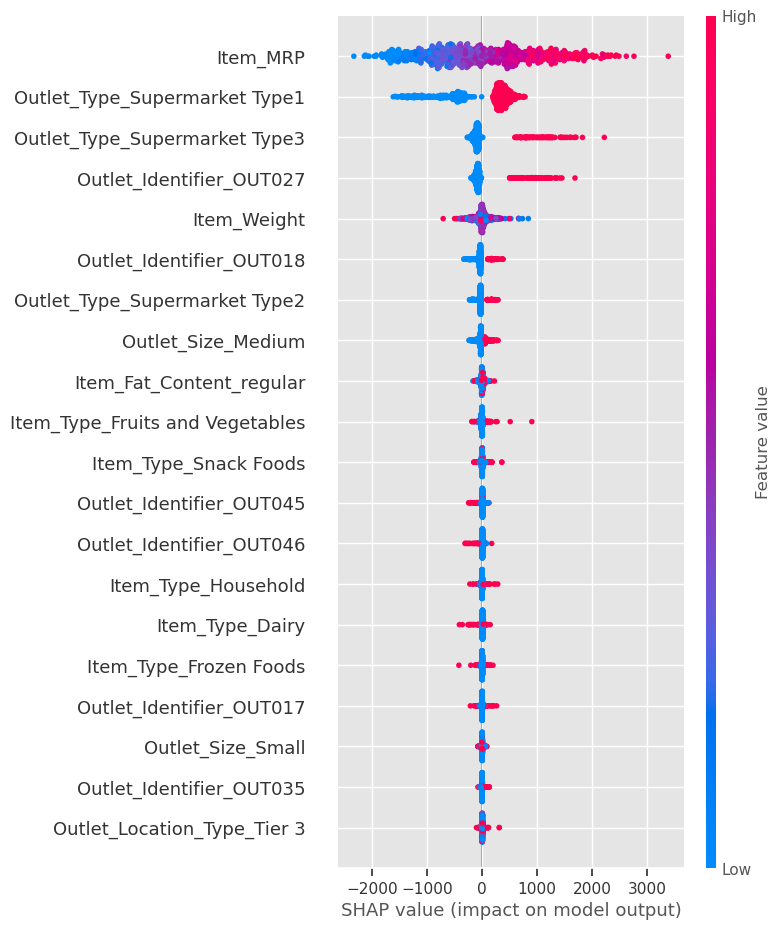

In [91]:
shap.summary_plot(shap_values,X_shap)

<img src="importances.png" width=60%>

in the shap plot item_mrp is the top important feature just as plot of important features so is outlet_type_supermarket type1 but in shap plots the most important 3rd feature is outlet_type_3 but in the plot of original feature importances figure the third important is item_weight and then the next important is out_let identifier_out027 where as in the feature important role, it is the last important feature from the 5 most important feature.outlet_type_supermarket type1 ,outlet_type_3  and outlet_identifier_OUT027 show that the higher their values the higher the model is going to predict the sales so they are most important features for predicting sales in shap where as in feature importances plot item_mrp, outlet type supermarket type 1, item weight and the others follow.

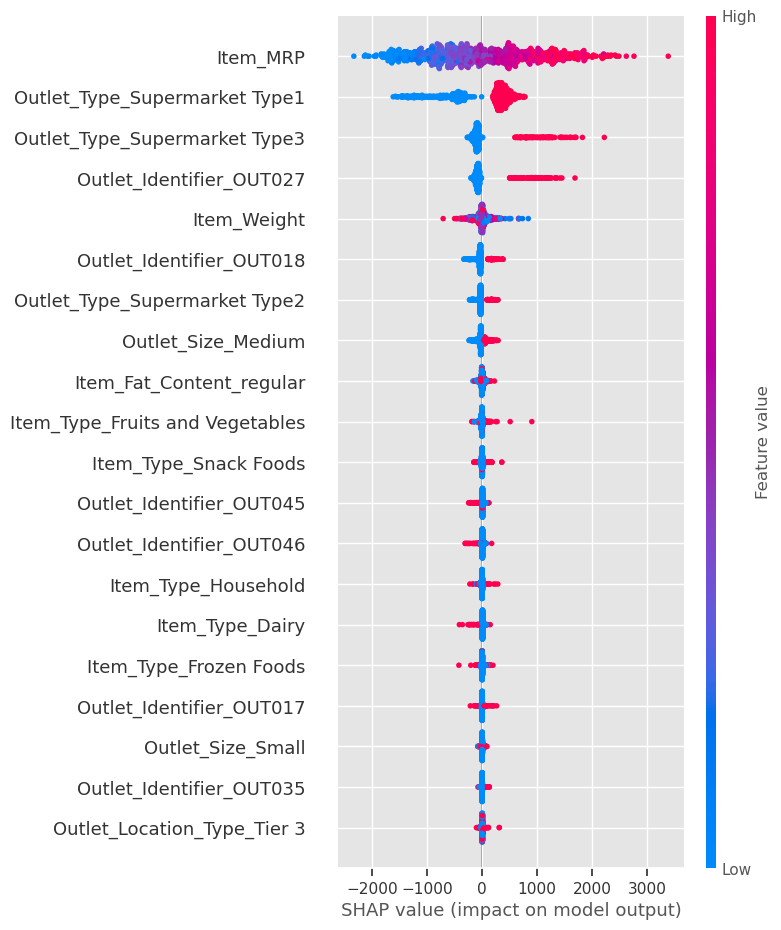

In [92]:
## create a summary plot (dot version)
shap.summary_plot(shap_values, features = X_shap, plot_type='dot')

# Interpreting the SHAP values for our model:
 
  ## ITEM_MRP
    
  since positive values are on the right, we can see that the greater the number of ITEM_MRP , the more likely the model would predict the sales .we see that at the left, the blue values, for the lower  values of ITEM_MRP, the less likely the model will predict the sales that is towards the left.The lowest the values of the ITEM_MRP the less chance it will pridicting  the sales.so the higher values of the item_mrp the more likely it's going to pridict the sales.

## outlet_type_supermartket_type1

since the red value is on the right, the more the values of outlet_type_supermarket_type1, the more likely it is going to predict the sales

## outlet_type_supermartket_type3

In here also, the more the values of the ourtlet_type_supermarket_type3, the more chances of predicting the sales.( direct relation)

# LOCAL EXPLANATIONS

store that had low sales ( one of the lowest values for my target) and one with high sales (the highest values for my target).

I choose the ITEM_MRP AND Outlet_Location_type_Tier 3 with the highest and the lowest values of sales.

### a Lime tabular explanation
- Interpret what features most heavily influenced the predictions, according to LIME.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README). Note: you will need to take a screenshot to save the lime explanation.

In [113]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)

In [131]:
X_shap_local.head()

Item_Weight  Item_MRP  Item_Fat_Content_regular  Item_Type_Breads  \
0        15.85   36.9506                       1.0               0.0   
1        15.10  221.8456                       1.0               0.0   
2        17.50  184.8266                       0.0               0.0   
3        10.80  243.2144                       0.0               0.0   
4        15.00  140.4838                       0.0               0.0   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
0                  0.0               0.0              0.0   
1                  0.0               0.0              0.0   
2                  0.0               0.0              0.0   
3                  0.0               0.0              0.0   
4                  0.0               0.0              0.0   

   Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
0                     1.0                              0.0   
1                     0.0                              1.0   
2                     0.0                              1.0   
3                     0.0                              1.0   
4                     0.0                              0.0   

   Item_Type_Hard Drinks  ...  Outlet_Identifier_OUT046  \
0                    0.0  ...                       0.0   
1                    0.0  ...                       1.0   
2                    0.0  ...                       0.0   
3                    0.0  ...                       0.0   
4                    0.0  ...                       0.0   

   Outlet_Identifier_OUT049  Outlet_Size_MISSING  Outlet_Size_Medium  \
0                       0.0                  1.0                 0.0   
1                       0.0                  0.0                 0.0   
2                       0.0                  1.0                 0.0   
3                       0.0                  1.0                 0.0   
4                       0.0                  1.0                 0.0   

   Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
0                0.0                          1.0   
1                1.0                          0.0   
2                0.0                          1.0   
3                0.0                          1.0   
4                0.0                          1.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
0                          0.0                            1.0   
1                          0.0                            1.0   
2                          0.0                            1.0   
3                          0.0                            1.0   
4                          0.0                            1.0   

   Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
0                            0.0                            0.0  
1                            0.0                            0.0  
2                            0.0                            0.0  
3                            0.0                            0.0  
4                            0.0                            0.0  

[5 rows x 35 columns]

In [130]:
shap_values = explainer(X_shap_local,y_shap_local)
shap_values.shape

(800, 35)

In [132]:
X_shap_local.shape

(800, 35)

In [99]:
y_shap_local.head()

0     759.0120
1     663.1368
2    2766.3990
3    1225.0720
4    1685.8056
Name: Item_Outlet_Sales, dtype: float64

# LIME EXPLANATION

In [120]:
X_shap_local['Item_MRP'].describe()

count    800.000000
mean     142.938125
std       62.792657
min       32.055800
25%       97.596300
50%      141.882500
75%      188.221400
max      265.222600
Name: Item_MRP, dtype: float64

In [115]:
## saving the index of the most deaths
idx_high_sales = X_shap_local['Item_MRP'].idxmax()
idx_high_sales

171

In [116]:
X_shap_local.iloc[idx_high_sales]

Item_Weight                         10.0000
Item_MRP                           265.2226
Item_Fat_Content_regular             0.0000
Item_Type_Breads                     0.0000
Item_Type_Breakfast                  0.0000
Item_Type_Canned                     1.0000
Item_Type_Dairy                      0.0000
Item_Type_Frozen Foods               0.0000
Item_Type_Fruits and Vegetables      0.0000
Item_Type_Hard Drinks                0.0000
Item_Type_Health and Hygiene         0.0000
Item_Type_Household                  0.0000
Item_Type_Meat                       0.0000
Item_Type_Others                     0.0000
Item_Type_Seafood                    0.0000
Item_Type_Snack Foods                0.0000
Item_Type_Soft Drinks                0.0000
Item_Type_Starchy Foods              0.0000
Outlet_Identifier_OUT013             0.0000
Outlet_Identifier_OUT017             0.0000
Outlet_Identifier_OUT018             0.0000
Outlet_Identifier_OUT019             0.0000
Outlet_Identifier_OUT027        

In [117]:
## what was the actual item_mrp?
y_shap_local.iloc[idx_high_sales]

5815.0972

In [118]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [119]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_sales],
                                      loaded_model.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


As we can see above, this item type has a predicted value of sales which is 5158 dollars of predicted value.
This item_mrp has negative impacts from features in predicting sales such as outlet_type supermarket(uknown), item_type breads, item_type_fruits, and item_type_others while features that helped it or has postive influences are item_MRP which is greater than 188.22 and outlet type _supermarket type 1 which is greater than 0 also item type seafood has postively contributed to the prediction of sales.

In [121]:
X_shap_local['Item_Weight'].describe()

count    800.000000
mean      13.025826
std        4.163595
min        4.555000
25%        9.671250
50%       12.904458
75%       16.000000
max       21.250000
Name: Item_Weight, dtype: float64

In [123]:
## saving the index of the most deaths
idx_high_weight = X_shap_local['Item_Weight'].idxmax()
idx_high_weight

719

In [124]:
X_shap_local.iloc[idx_high_weight]

Item_Weight                         21.2500
Item_MRP                           147.4102
Item_Fat_Content_regular             0.0000
Item_Type_Breads                     0.0000
Item_Type_Breakfast                  0.0000
Item_Type_Canned                     0.0000
Item_Type_Dairy                      0.0000
Item_Type_Frozen Foods               0.0000
Item_Type_Fruits and Vegetables      0.0000
Item_Type_Hard Drinks                0.0000
Item_Type_Health and Hygiene         0.0000
Item_Type_Household                  1.0000
Item_Type_Meat                       0.0000
Item_Type_Others                     0.0000
Item_Type_Seafood                    0.0000
Item_Type_Snack Foods                0.0000
Item_Type_Soft Drinks                0.0000
Item_Type_Starchy Foods              0.0000
Outlet_Identifier_OUT013             0.0000
Outlet_Identifier_OUT017             1.0000
Outlet_Identifier_OUT018             0.0000
Outlet_Identifier_OUT019             0.0000
Outlet_Identifier_OUT027        

In [125]:
## what was the actual life expectancy?
y_shap_local.iloc[idx_high_weight]

3791.0652

In [126]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [128]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_weight],
                                      loaded_model.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


in here, we can see that item_wight has a value of 3069.86 dollars in predition of sales at this example. 
all the other columns except for outlet type supermarket type 1 and item_mrp of value 147.41 which have postively influecnced towards maximum item_weight.and hence sales.
the outlet_type wis postive with value greater than 0 while item_mrp greater than 141.88.

# Global Force Plot

In [133]:
## Global Force Plot 
shap.force_plot(explainer.expected_value, shap_values.values, features=X_shap_local)

In [135]:
## saving the index of the highest values of item_mrp
idx_item_MRP = X_shap_local['Item_MRP'].idxmax()
idx_item_MRP

171

In [136]:
## plotting example force plot for item_mrp
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_item_MRP].values,
               features=X_shap_local.iloc[idx_item_MRP])

as can be seen in the force plot, the features that helped greatly for the prediction of sales are ITEM_MRP which has 265.2 value, item_weight with values of 10 and outlet_type_supermarket type 1, the other features have lower values so not very important for the prediction of sales.

In [137]:
# for the second example of item_weight

In [138]:
## plotting example force plot for item_mrp
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_high_weight].values,
               features=X_shap_local.iloc[idx_high_weight])

outlet_type_supermarket type1 has the greater contribution to prediction of the sales,item_mrp has the second with values of 147.4 and item_weight which has values of 21.25  and item_type_household=1, the other features were not important for predicion of sales.